# A notebook for trying out and subsequently analyzing various preprocessing and feature engineering techniques with the goal of improving model performance.
- ## Although our team is currently in first place, I believe that we can still deeply improve on our performance and keep growing/ learning as fledgling Data Scientists

## Basic imports, and loading in our preprocessed data.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
train_df = pd.read_csv("checkpoint_train_v1.csv", encoding = 'utf-8')

In [4]:
test_df = pd.read_csv("checkpoint_test_v1.csv", encoding = 'utf-8')

## Set all non-float columns back to integers, round float columns to hundreths.
### Hopefully, this will reduce noise, and increase predictability

#### Train Data

In [5]:
train_df['release_date'] = train_df['release_date'].astype(int)
train_df['runtime'] = train_df['runtime'].astype(int)
train_df['vote_count'] = train_df['vote_count'].astype(int)
train_df['movieId'] = train_df['movieId'].astype(int)
train_df['userId'] = train_df['userId'].astype(int)

In [6]:
train_df['revenue'] = train_df['revenue'].round(2)
train_df['budget'] = train_df['budget'].round(2)
train_df['popularity'] = train_df['popularity'].round(2)
train_df['vote_average'] = train_df['vote_average'].round(2)

#### Test Data

In [7]:
test_df['release_date'] = test_df['release_date'].astype(int)
test_df['runtime'] = test_df['runtime'].astype(int)
test_df['vote_count'] = test_df['vote_count'].astype(int)
test_df['movieId'] = test_df['movieId'].astype(int)
test_df['userId'] = test_df['userId'].astype(int)

In [8]:
test_df['revenue'] = test_df['revenue'].round(2)
test_df['budget'] = test_df['budget'].round(2)
test_df['popularity'] = test_df['popularity'].round(2)
test_df['vote_average'] = test_df['vote_average'].round(2)

## Idea: Transform Part of Collection column into a binary feature depending on wether or not it is a part of a collection
### Hopefully, this will make use of an un-utilized feature

#### Train Data

In [9]:
train_df['part_of_collection'] = train_df['part_of_collection'].apply(lambda x: 0 if x == 'not available' else 1)

In [10]:
train_df['part_of_collection'].head(2)

0    0
1    1
Name: part_of_collection, dtype: int64

#### Test Data

In [11]:
test_df['part_of_collection'] = test_df['part_of_collection'].apply(lambda x: 0 if x == 'not available' else 1)

In [12]:
test_df['part_of_collection'].head(2)

0    1
1    0
Name: part_of_collection, dtype: int64

#### Checking for correlation

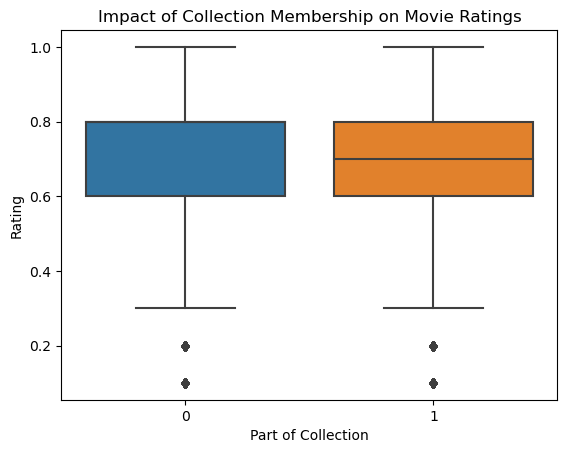

In [13]:
data = train_df[['part_of_collection', 'rating']]
sns.boxplot(x='part_of_collection', y='rating', data = data)
plt.title('Impact of Collection Membership on Movie Ratings')
plt.xlabel('Part of Collection')
plt.ylabel('Rating')
plt.show()

#### Analysis / Conclusion

It does not seem as though our part of collection variable is having any kind of impact on our target variable, rating. I am going to take this as a sign that it does not have much feature correlation, and at least for now, drop the column from the training and test sets.

In [112]:
train_df.drop(columns = 'part_of_collection', inplace = True)
test_df.drop(columns = 'part_of_collection', inplace = True)

## Idea: Create a binary feature based on a movie being in the 10th percentile and 90th percentile of its years' revenue, basically, monitarily successful or not

#### Setup

In [14]:
''' Calculate 10th and 90th percentile of revenue '''

tenth_percentile_revenue = train_df.groupby('release_date')['revenue'].quantile(.1)
ninetieth_percentile_revenue = train_df.groupby('release_date')['revenue'].quantile(.9)

In [15]:
''' Define function for creating binary column based on our conditions'''

def is_high_revenue(row):
    release_date = row['release_date']
    revenue = row['revenue']
    ninetieth_percentile = ninetieth_percentile_revenue.loc[release_date]
    return revenue >= ninetieth_percentile

def is_low_revenue(row):
    release_date = row['release_date']
    revenue = row['revenue']
    tenth_percentile = tenth_percentile_revenue.loc[release_date]
    return revenue <= tenth_percentile

#### Train Data

In [16]:
train_df['high_revenue'] = train_df.apply(is_high_revenue, axis=1)
train_df['low_revenue'] = train_df.apply(is_low_revenue, axis=1)

In [17]:
train_df[['high_revenue', 'low_revenue']].head(2)

,high_revenue,low_revenue
0,False,False
1,True,False


#### Test Data

In [18]:
test_df['high_revenue'] = test_df.apply(is_high_revenue, axis=1)
test_df['low_revenue'] = test_df.apply(is_low_revenue, axis=1)

In [19]:
test_df[['high_revenue', 'low_revenue']].head(2)

,high_revenue,low_revenue
0,True,False
1,True,False


### At this point the model performance is at: 0.1739. 
- #### Try scaling the data, and performing apples to apples comparison to see if scaling has value
- #### Adjust the bool columns to integers
- - #### After scaling, score was 0.1740, probably not worth it

In [23]:
from tqdm import tqdm 
from sklearn.preprocessing import StandardScaler

In [22]:
''' Isolate all non-binary numerical Columns '''

numerical_columns = ['release_date', 'budget', 'popularity', 'revenue', 
                     'runtime', 'vote_average', 'vote_count']

In [24]:
''' Define a standardization scaling algorithm, check for null values, apply '''

scaler = StandardScaler() # Define algorithm

for col in tqdm(numerical_columns):
    if train_df[col].isnull().any(): # Check for Nulls
        
        train_df[col].fillna(train_df[col].mean(), inplace=True)
        test_df[col].fillna(train_df[col].mean(), inplace=True)
        
    if col in test_df.columns: # Apply transformation to test df

        train_df[col] = scaler.fit_transform(train_df[[col]])
        test_df[col] = scaler.transform(test_df[[col]])
        
    else: # Apply transformation to train df
        train_df[col] = scaler.fit_transform(train_df[[col]])

100%|██████████| 7/7 [00:00<00:00, 54.72it/s]


In [28]:
train_df[['high_revenue', 'low_revenue']] = train_df[['high_revenue', 'low_revenue']].astype(int)
test_df[['high_revenue', 'low_revenue']] = test_df[['high_revenue', 'low_revenue']].astype(int)

In [29]:
train_df.head(1)

,rating,userId,movieId,budget,overview,popularity,release_date,revenue,runtime,tagline,...,Adventure,Romance,Family,TV Movie,Mystery,War,Documentary,History,high_revenue,low_revenue
0,0.4,10,1358,-1.70091,Karl Childers is a mentally disabled man who h...,0.501803,0.278193,-0.028445,1.32168,A simple man A difficult choice,...,0,0,0,0,0,0,0,0,0,0


In [30]:
test_df.head(1)

,userId,movieId,budget,overview,popularity,release_date,revenue,runtime,tagline,title,...,Adventure,Romance,Family,TV Movie,Mystery,War,Documentary,History,high_revenue,low_revenue
0,469,2124,0.821147,Uncle Fester has been missing for 25 years An ...,0.501803,-0.054576,0.674398,-0.74909,Weird Is Relative,The Addams Family,...,0,0,0,0,0,0,0,0,1,0


##### Export for comparison!

In [31]:
train_df.to_csv('checkpoint_train.csv', encoding = 'utf-8', index = False)
test_df.to_csv('checkpoint_test.csv', encoding = 'utf-8', index = False)

#### The Model ended up getting a 0.174 RMSE score, which leads me to believe, at least this scaling technique, is not going to improve performance at all. I am still pretty convinced that if we can figure out how to include some kind of predictability from text features, model will do better. 

## Idea: Drop the Genres Column and see if it improves performance at all. Result: To be determined, hasnt been compared "apples-to-apples" yet

In [121]:
genre_columns =     ['Science Fiction', 'Crime', 'Thriller', 
                     'Horror', 'Romance', 'TV Movie', 'Action', 
                     'Adventure', 'War', 'Documentary', 'Family', 
                     'Fantasy', 'Music', 'Animation', 'Mystery', 
                     'Western', 'Foreign', 'History', 'Drama', 'Comedy']

In [124]:
train_df.drop(columns = genre_columns, inplace = True)
test_df.drop(columns = genre_columns, inplace = True)

In [127]:
train_df.head(1)

,rating,userId,movieId,budget,overview,popularity,release_date,revenue,runtime,tagline,title,vote_average,vote_count,all_keywords,old,high_revenue,low_revenue
0,0.4,10,1358,1000000.0,Karl Childers is a mentally disabled man who h...,8.46,1996,24444121.0,135,A simple man A difficult choice,Sling Blade,7.4,109,independent film repair shop southern death th...,0.0,False,False


# Check Feature Importances 

In [34]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import ensemble

In [35]:
text_columns = ['overview', 'tagline', 'title', 'all_keywords']
train_df.drop(columns = text_columns, inplace = True)
test_df.drop(columns = text_columns, inplace = True)

In [88]:
y_train = train_df['rating']
X_train = train_df.drop(labels = 'rating', axis = 1)

X_test = test_df

parameters = {
    "n_estimators": 960,
    "max_depth": 4,
    "min_samples_split": 15,
    "random_state": 150,
    'subsample': 0.75,
    "learning_rate": 0.2,
    "loss": "squared_error"

}
GB_regressor = ensemble.GradientBoostingRegressor(**parameters)
GB_regressor.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.2, max_depth=4, min_samples_split=15,
                          n_estimators=960, random_state=150, subsample=0.75)

#### Check Feature importance

In [89]:
''' Get Feature importances '''
feature_importances = GB_regressor.feature_importances_

''' Create a DataFrame with feature names and importances '''
df_feature_importances = pd.DataFrame({'Feature': train_df.drop(columns = 'rating').columns, 'Importance': feature_importances})

''' Sort values based on importance '''
df_feature_importances = df_feature_importances.sort_values('Importance', ascending = False)

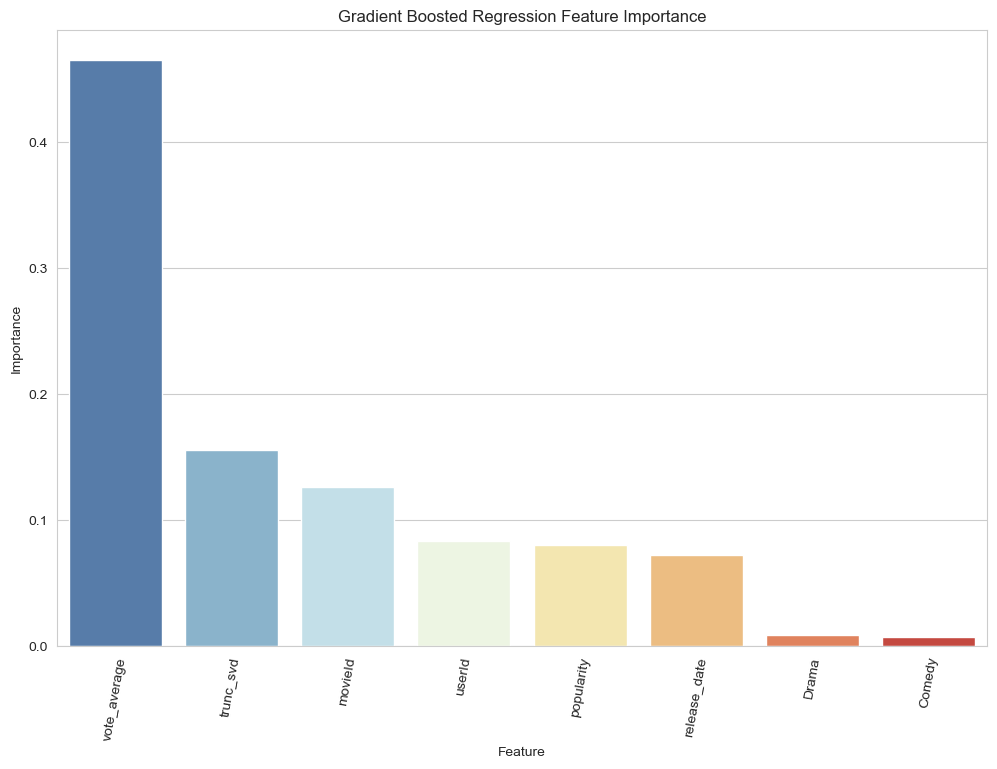

In [90]:
''' Make it pretty, plot the data '''
colors = sns.color_palette("mako_r", len(df_feature_importances))
plt.figure(figsize = (12, 8))
sns.set_style('whitegrid')
sns.barplot(x = 'Feature', y = 'Importance', data = df_feature_importances, palette = 'RdYlBu_r')
plt.xticks(rotation = 80)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Gradient Boosted Regression Feature Importance')
plt.show()

## Export for Testing

In [20]:
train_df.to_csv('checkpoint_train.csv', encoding = 'utf-8', index = False)
test_df.to_csv('checkpoint_test.csv', encoding = 'utf-8', index = False)

In [128]:
to_drop = ['old', 'high_revenue', 'low_revenue']

In [129]:
train_df.drop(columns = to_drop, inplace = True)
test_df.drop(columns = to_drop, inplace = True)